## Librerías

In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ['TF_ENABLE_ONEDNN_OPTS'] =  "0"



import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy

from tensorflow import keras 
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist

## Librerías
import seaborn as sns
import sys
import cv2 as cv2
import glob
from PIL import Image
import tensorflow as tf
import sys
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import gc
import tensorflow.keras as keras
from sklearn.model_selection import train_test_split
import os


from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.preprocessing import StandardScaler

print(tf.__version__)

2.14.0


In [2]:
## Uso de GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpus[0], True)

2023-11-22 21:06:28.049570: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 21:06:28.109489: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 21:06:28.109648: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

## Dataset

In [3]:
## Obtener todas las rutas de las imágenes en el dataset
ruta = '../Datasets/Micrografías_segmentadas/secas/*/*/*/*.jpg'
rutas_dataset  = glob.glob('../../../Datasets/Micrografías segmentaciones/secas/*/*/*/*.jpg')

## Separar rutas
mask_list = []
image_list = []
for ruta in rutas_dataset:    
    ruta_list = ruta.split('/')       
    clase = ruta_list[6]
    number = ruta_list[7]
    tipo = ruta_list[8]
    name = ruta_list[9].split('.')[0]
    
    if tipo == 'train':
        image_list.append([name,ruta,clase,number])
    elif tipo == 'mask_bin':
        mask_list.append([name,ruta,clase,number])
    else:
        None

mask_pd = pd.DataFrame(mask_list,columns=['name','route_mask','label','number']).sort_values(by='name')
image_pd = pd.DataFrame(image_list,columns=['name','route_image','label','number']).sort_values(by='name')

routes_dataset = image_pd.merge(mask_pd,on=['name','label','number'],how='left')

routes_dataset.dropna(inplace=True)

routes_dataset = routes_dataset.sample(frac = 1)

print('Imágenes secas:', np.shape(routes_dataset)[0])
print('MF1:', '- secas: ', np.shape(routes_dataset[routes_dataset['label']=='MF1'])[0])
print('MF2:', '- secas: ', np.shape(routes_dataset[routes_dataset['label']=='MF2'])[0])
print('MF3:', '- secas: ', np.shape(routes_dataset[routes_dataset['label']=='MF3'])[0])

char_to_num = {'MF1':'0','MF2':'1','MF3':'2'}

routes_dataset['label'].replace(char_to_num,inplace=True)

routes_dataset

Imágenes secas: 923
MF1: - secas:  378
MF2: - secas:  284
MF3: - secas:  261


,name,route_image,label,number,route_mask
512,IMG_20230711_154750_jpg,../../../Datasets/Micrografías segmentaciones/...,1,1,../../../Datasets/Micrografías segmentaciones/...
902,IMG_20230711_222452_jpg,../../../Datasets/Micrografías segmentaciones/...,2,5,../../../Datasets/Micrografías segmentaciones/...
84,IMG_20230602_221611_jpg,../../../Datasets/Micrografías segmentaciones/...,2,4,../../../Datasets/Micrografías segmentaciones/...
638,IMG_20230711_170129_jpg,../../../Datasets/Micrografías segmentaciones/...,1,4,../../../Datasets/Micrografías segmentaciones/...
874,IMG_20230711_214922_jpg,../../../Datasets/Micrografías segmentaciones/...,2,6,../../../Datasets/Micrografías segmentaciones/...
...,...,...,...,...,...
93,IMG_20230602_222118_jpg,../../../Datasets/Micrografías segmentaciones/...,2,4,../../../Datasets/Micrografías segmentaciones/...
320,IMG_20230707_180425_jpg,../../../Datasets/Micrografías segmentaciones/...,0,5,../../../Datasets/Micrografías segmentaciones/...
315,IMG_20230707_180356_jpg,../../../Datasets/Micrografías segmentaciones/...,0,5,../../../Datasets/Micrografías segmentaciones/...
427,IMG_20230707_191253_jpg,../../../Datasets/Micrografías segmentaciones/...,0,7,../../../Datasets/Micrografías segmentaciones/...


In [4]:
## Establecer el porcentaje de separación
thold1 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='0'])))
thold2 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='1'])))
thold3 = int(np.ceil(0.8 * len(routes_dataset[routes_dataset.label=='2'])))

## Separar por clases para entrenamiento
train_cu1 = routes_dataset[routes_dataset.label == '0'][0:thold1]
train_cu2 = routes_dataset[routes_dataset.label == '1'][0:thold2]
train_cu3 = routes_dataset[routes_dataset.label == '2'][0:thold3]

## tomar las demás imágenes para test
test_cu1 = routes_dataset[routes_dataset.label == '0'][thold1:]
test_cu2 = routes_dataset[routes_dataset.label == '1'][thold2:]
test_cu3 = routes_dataset[routes_dataset.label == '2'][thold3:]


## Constuir un solo dataset de training
train_df =  pd.concat([pd.concat([train_cu1,train_cu2]),train_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Construir un solo dataset de test
test_df = pd.concat([pd.concat([test_cu1,test_cu2]),test_cu3]).sample(frac=1,random_state=42).reset_index(drop=True)

## Cantidad de muestras por clase
print('Clase MF1: train: ',len(train_cu1),', test: ',len(test_cu1))
print('Clase MF2: train: ',len(train_cu2),', test: ',len(test_cu2))
print('Clase MF3: train: ',len(train_cu3),', test: ',len(test_cu3))

Clase MF1: train:  303 , test:  75
Clase MF2: train:  228 , test:  56
Clase MF3: train:  209 , test:  52


In [6]:
def get_contours_and_features(binary_map):
    #contours_map  = np.zeros_like(binary_map)
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contours_map = cv2.drawContours(contours_map, contours, -1, 255, 1)
    contours_features = []
    for contour in contours:
        error = 1e-5

        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        features = {
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features    
    return contours_features

def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    atributes = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)        

        ## obtener área de poros
        area = np.ceil(np.sum(get_item(contour_features, key='area')))

        ## obtener perímetro de poros
        perimetro = np.ceil(np.sum(get_item(contour_features, key='perimeter'))
)
        ## intersticio
        area_total = np.ceil(np.shape(image)[0] * np.shape(image)[1])
        intersticio = np.ceil(area_total - area)

        ## Cantidad de poros
        poros = np.shape(contour_features)[0]

        #atributes = [area,perimetro,intersticio,poros]
        atributes.append([area,perimetro,intersticio,poros])
    
    return atributes

def create_dataset(buffer,file_names, labels, file_mask):    
  images = get_binary_image(file_mask)
  attributes = get_geometric_atributes(images)
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes ))
  dataset.shuffle(buffer_size=buffer)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes ))

  return dataset

file_names = train_df['route_image'].to_numpy()
file_mask = train_df['route_mask'].to_numpy()
labels = train_df['label'].to_numpy()
dataset = create_dataset(16,file_names, labels,file_mask)

2023-11-22 21:07:07.621067: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 21:07:07.621784: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-22 21:07:07.621905: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:894] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

[7039. 1784. 9345.   24.]
b'0'


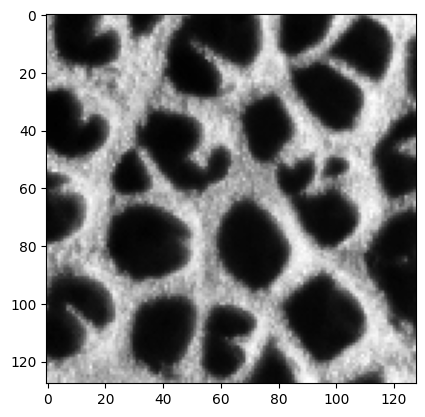

In [7]:
cnt = 0
for i in dataset.batch(16):
    a = i[0]
    b = i[1]
    c = i[2]

n =  0
print(c[n].numpy())
print(b[n].numpy())
plt.imshow(a[n],cmap='gray')

## Modelo

In [8]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [9]:
### Approach 2

encoder = keras.models.load_model('Models/weakly2_GVAE_encoder_DRY_1_32.h5', custom_objects={'Sampling':Sampling})
decoder = keras.models.load_model('Models/weakly2_GVAE_decoder_DRY_1_32.h5', custom_objects={'Sampling':Sampling})
regressor = keras.models.load_model('Models/weakly2_GVAE_regressor_DRY_1_32.h5', custom_objects={'Sampling':Sampling})

In [13]:
test_df

,name,route_image,label,number,route_mask
0,IMG_20230707_171003_jpg,../../../Datasets/Micrografías segmentaciones/...,0,3,../../../Datasets/Micrografías segmentaciones/...
1,IMG_20230707_184517_jpg,../../../Datasets/Micrografías segmentaciones/...,0,6,../../../Datasets/Micrografías segmentaciones/...
2,IMG_20230602_221534_jpg,../../../Datasets/Micrografías segmentaciones/...,2,4,../../../Datasets/Micrografías segmentaciones/...
3,IMG_20230711_161306_jpg,../../../Datasets/Micrografías segmentaciones/...,1,2,../../../Datasets/Micrografías segmentaciones/...
4,IMG_20230602_210357_jpg,../../../Datasets/Micrografías segmentaciones/...,2,3,../../../Datasets/Micrografías segmentaciones/...
...,...,...,...,...,...
178,IMG_20230711_163554_jpg,../../../Datasets/Micrografías segmentaciones/...,1,3,../../../Datasets/Micrografías segmentaciones/...
179,IMG_20230707_164227_jpg,../../../Datasets/Micrografías segmentaciones/...,0,2,../../../Datasets/Micrografías segmentaciones/...
180,IMG_20230711_161254_jpg,../../../Datasets/Micrografías segmentaciones/...,1,2,../../../Datasets/Micrografías segmentaciones/...
181,IMG_20230711_212841_jpg,../../../Datasets/Micrografías segmentaciones/...,2,7,../../../Datasets/Micrografías segmentaciones/...


In [27]:
def get_contours_and_features(binary_map):
    #contours_map  = np.zeros_like(binary_map)
    binary_map = cv2.cvtColor(binary_map, cv2.COLOR_BGR2GRAY)
    contours, hierarchy = cv2.findContours(binary_map, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
    #contours_map = cv2.drawContours(contours_map, contours, -1, 255, 1)
    contours_features = []
    for contour in contours:
        error = 1e-5

        moments = cv2.moments(contour)
        cx = moments['m10'] / (moments['m00'] + error)
        cy = moments['m01'] / (moments['m00'] + error)
        center_of_mass = [cx, cy]
        features = {
            'area': cv2.contourArea(contour),
            'perimeter': cv2.arcLength(contour, True),
            'moments': moments,
            'center_of_mass': center_of_mass,
            'contour': contour
        }
        contours_features.append(features)
        del features    
    return contours_features

def get_item(contour_features, key='area'):
    areas = []
    for contour_feature in contour_features:
        area =  contour_feature[key]
        areas.append(area)
    return areas

def load_image(file_name):
  raw = tf.io.read_file(file_name)
  tensor = tf.io.decode_jpeg(raw,channels=1)
  tensor = tf.image.resize(tensor, [128,128])
  tensor = tf.cast(tensor, tf.float32) / 255.0
  return tensor

def get_binary_image(filenames):
    tensores = []
    for filename in filenames:
        raw = tf.io.read_file(filename)
        tensor = tf.io.decode_jpeg(raw,channels=3)
        tensor = tf.image.resize(tensor, [128,128])
        tensor = tf.cast(tensor, tf.float32) / 255.0
        tensores.append(tensor)
    return tensores

def get_geometric_atributes(binary_images):
    atributes = []
    for binary_img in binary_images:
        ## Formato
        image = binary_img.numpy().astype(np.uint8)       
        
        ## Capturar contornos
        contour_features = get_contours_and_features(image)        

        ## obtener área de poros
        area = np.ceil(np.sum(get_item(contour_features, key='area')))

        ## obtener perímetro de poros
        perimetro = np.ceil(np.sum(get_item(contour_features, key='perimeter'))
)
        ## intersticio
        area_total = np.ceil(np.shape(image)[0] * np.shape(image)[1])
        intersticio = np.ceil(area_total - area)

        ## Cantidad de poros
        poros = np.shape(contour_features)[0]

        #atributes = [area,perimetro,intersticio,poros]
        atributes.append([area,perimetro,intersticio,poros])
    
    return atributes

def create_dataset(buffer,file_names, labels, file_mask):    
  images = get_binary_image(file_mask)
  attributes = get_geometric_atributes(images)
  dataset = tf.data.Dataset.from_tensor_slices((file_names,labels,attributes ))
  dataset.shuffle(buffer_size=buffer)
  dataset = dataset.map(lambda file_name, label, attributes : (load_image(file_name), label, attributes ))
  
  return dataset

file_names_test = test_df['route_image'].to_numpy()
file_mask_test = test_df['route_mask'].to_numpy()
labels_test = test_df['label'].to_numpy()
dataset_test = create_dataset(16,file_names_test, labels_test,file_mask_test)


In [85]:
x_test = []
y_test_labels = []
y_test_props = []

### Guardar información del dataset test en listas
cnt = 0
for i in dataset_test.batch(1):
    ## Imagen
    img = np.array(i[0].numpy()[0]) 
    img /= 255
    x_test.append(img)
    ## Clase
    y_test_labels.append(i[1].numpy()[0])
    ## Propiedades
    y_test_props.append(i[2].numpy()[0].tolist())


## Generar embebido
embs = encoder.predict(np.array(x_test))

## Generar reconstrucción
recons = decoder.predict(embs[2])

## Generar predicción de propiedades desde reconstrucción
preds = regressor.predict(recons)

6/6 [==============================] - 0s 2ms/step


In [86]:
### Calcular errores por métrica
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
area_label = []
interstice_label = []
perimeter_label = []
npores_label = []

area_pred = []
interstice_pred = []
perimeter_pred = []
npores_pred = []

area_error = []

for i in range(len(preds)):
    area_label.append(y_test_props[i][0])
    perimeter_label.append(y_test_props[i][1])
    interstice_label.append(y_test_props[i][2])
    npores_label.append(y_test_props[i][3])

    area_pred.append(preds[i][0])
    perimeter_pred.append(preds[i][1])
    interstice_pred.append(preds[i][2])
    npores_pred.append(preds[i][3])
    
    # area relative error
    area_error.append(np.abs((y_test_props[i][0] - preds[i][0]) / y_test_props[i][0]))

print("---------------------------------------------------")

print('MSE area:',mean_squared_error(area_label,area_pred))
print('MSE interstice:',mean_squared_error(interstice_label,interstice_pred))
print('MSE perimeter:',mean_squared_error(perimeter_label,perimeter_pred))
print('MSE npores:',mean_squared_error(npores_label,npores_pred))

print("---------------------------------------------------")
print('MAE area:',mean_absolute_error(area_label,area_pred))
print('MAE interstice:',mean_absolute_error(interstice_label,interstice_pred))
print('MAE perimeter:',mean_absolute_error(perimeter_label,perimeter_pred))
print('MAE npores:',mean_absolute_error(npores_label,npores_pred))

print("---------------------------------------------------")
print('R2 area:',r2_score(area_label,area_pred))
print('R2 interstice:',r2_score(interstice_label,interstice_pred))
print('R2 perimeter:',r2_score(perimeter_label,perimeter_pred))
print('R2 npores:',r2_score(npores_label,npores_pred))

print("---------------------------------------------------")
print('Relative errors:')
print('Relative error area:',np.mean(area_error))
print('Relative error interstice:',np.mean(np.abs((np.array(interstice_label) - np.array(interstice_pred)) / np.array(interstice_label))))
print('Relative error perimeter:',np.mean(np.abs((np.array(perimeter_label) - np.array(perimeter_pred)) / np.array(perimeter_label))))
print('Relative error npores:',np.mean(np.abs((np.array(npores_label) - np.array(npores_pred)) / np.array(npores_label))))


### 1. No estimando areas F
### 2. Los poros no dan entenros -> forzarlos a que sean enteros
## SOLUCIÓN 1: NORMALIZAR PROPIEDADES

---------------------------------------------------
MSE area: 40444471.36612022
MSE interstice: 5178018.601434073
MSE perimeter: 457491.93615425914
MSE npores: 619.6973549657374
---------------------------------------------------
MAE area: 6342.48087431694
MAE interstice: 2223.621475303108
MAE perimeter: 503.9286462335639
MAE npores: 20.119878404127444
---------------------------------------------------
R2 area: -185.03051643140387
R2 interstice: -22.817086538139645
R2 perimeter: -0.7521847692244359
R2 npores: -0.0216501300356311
---------------------------------------------------
Relative errors:
Relative error area: 1.0
Relative error interstice: 0.21973461525047377
Relative error perimeter: 0.19419845802693972
Relative error npores: 0.45662722787669524


In [87]:
### Approach 1

encoder_1 = keras.models.load_model('Models/weaklyGVAE_encoder_DRY_1_32.h5', custom_objects={'Sampling':Sampling})
decoder_1 = keras.models.load_model('Models/weaklyGVAE_decoder_DRY_1_32.h5', custom_objects={'Sampling':Sampling})
regressor_1 = keras.models.load_model('Models/weaklyGVAE_regressor_DRY_1_32.h5', custom_objects={'Sampling':Sampling})

In [88]:
x_test = []
y_test_labels = []
y_test_props = []

### Guardar información del dataset test en listas
cnt = 0
for i in dataset_test.batch(1):
    ## Imagen
    img = np.array(i[0].numpy()[0]) 
    img /= 255
    x_test.append(img)
    ## Clase
    y_test_labels.append(i[1].numpy()[0])
    ## Propiedades
    y_test_props.append(i[2].numpy()[0].tolist())


## Generar embebido
embs = encoder_1.predict(np.array(x_test))

## Generar reconstrucción
recons = decoder_1.predict(embs[2])

## Generar predicción de propiedades desde reconstrucción
preds = regressor_1.predict(embs[2])

6/6 [==============================] - 0s 1ms/step


In [89]:
### Calcular errores por métrica
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
area_label = []
interstice_label = []
perimeter_label = []
npores_label = []

area_pred = []
interstice_pred = []
perimeter_pred = []
npores_pred = []

area_error = []

for i in range(len(preds)):
    area_label.append(y_test_props[i][0])
    perimeter_label.append(y_test_props[i][1])
    interstice_label.append(y_test_props[i][2])
    npores_label.append(y_test_props[i][3])

    area_pred.append(preds[i][0])
    perimeter_pred.append(preds[i][1])
    interstice_pred.append(preds[i][2])
    npores_pred.append(preds[i][3])
    
    # area relative error
    area_error.append(np.abs((y_test_props[i][0] - preds[i][0]) / y_test_props[i][0]))

print("---------------------------------------------------")

print('MSE area:',mean_squared_error(area_label,area_pred))
print('MSE interstice:',mean_squared_error(interstice_label,interstice_pred))
print('MSE perimeter:',mean_squared_error(perimeter_label,perimeter_pred))
print('MSE npores:',mean_squared_error(npores_label,npores_pred))

print("---------------------------------------------------")
print('MAE area:',mean_absolute_error(area_label,area_pred))
print('MAE interstice:',mean_absolute_error(interstice_label,interstice_pred))
print('MAE perimeter:',mean_absolute_error(perimeter_label,perimeter_pred))
print('MAE npores:',mean_absolute_error(npores_label,npores_pred))

print("---------------------------------------------------")
print('R2 area:',r2_score(area_label,area_pred))
print('R2 interstice:',r2_score(interstice_label,interstice_pred))
print('R2 perimeter:',r2_score(perimeter_label,perimeter_pred))
print('R2 npores:',r2_score(npores_label,npores_pred))

print("---------------------------------------------------")
print('Relative errors:')
print('Relative error area:',np.mean(area_error))
print('Relative error interstice:',np.mean(np.abs((np.array(interstice_label) - np.array(interstice_pred)) / np.array(interstice_label))))
print('Relative error perimeter:',np.mean(np.abs((np.array(perimeter_label) - np.array(perimeter_pred)) / np.array(perimeter_label))))
print('Relative error npores:',np.mean(np.abs((np.array(npores_label) - np.array(npores_pred)) / np.array(npores_label))))


### 1. No estimando areas F
### 2. Los poros no dan entenros -> forzarlos a que sean enteros
## SOLUCIÓN 1: NORMALIZAR PROPIEDADES

---------------------------------------------------
MSE area: 40444471.36612022
MSE interstice: 69519166.44154266
MSE perimeter: 3695156.854020734
MSE npores: 1520.878507160895
---------------------------------------------------
MAE area: 6342.48087431694
MAE interstice: 8324.826009781635
MAE perimeter: 1852.8783802803748
MAE npores: 30.146766011180773
---------------------------------------------------
R2 area: -185.03051643140387
R2 interstice: -318.76401219164995
R2 perimeter: -13.15237526138008
R2 npores: -1.5073622021433888
---------------------------------------------------
Relative errors:
Relative error area: 1.0
Relative error interstice: 0.8286753377376036
Relative error perimeter: 0.8161866965849016
Relative error npores: 0.5202055193002179
